O objetivo é responder à pergunta: postos embandeirados são mais fiscalizados que postos bandeira branca?

E se considerarmos que existem mais postos embandeirados, estes ainda recebem mais fiscalização? 

In [5]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
# import warnings

Dados de Fiscalização de Abastecimento retirados de [página da ANP](https://www.gov.br/anp/pt-br/centrais-de-conteudo/paineis-dinamicos-da-anp/painel-dinamico-da-fiscalizacao-do-abastecimento). No website é possível ver que os dados foram atualizados até 27/02/2024. São 427802 registros de dados.

In [10]:
# warnings.filterwarnings('ignore')

df_fiscalizacao_revenda = pd.read_csv("dados_brutos_112023.csv", sep=';', encoding='latin1')

num_registros = df_fiscalizacao_revenda["UF"].size

print("Numero de registros: ", num_registros)
df_fiscalizacao_revenda.head(4)

Numero de registros:  427802


,UF,Municï¿½pio,Bairro,Endereï¿½o,CNPJ/CPF,Agente Econï¿½mico,Segmento Fiscalizado,Data DF,Nï¿½mero do Documento,Procedimento de Fiscalizaï¿½ï¿½o,Resultado
0,AC,ACRELANDIA,ZONA RURAL,"RODOVIA BR 364 KM 96, M. DIREITA SENTIDO RIO B...",07481893000183,AUTO POSTO CAMARINI EIRELI,Revenda de Combustï¿½veis,08/07/2020,575385,Boletim de Fiscalizaï¿½ï¿½o,Aï¿½ï¿½o de fiscalizaï¿½ï¿½o em campo
1,AC,ACRELANDIA,ZONA RURAL,"RODOVIA BR 364 KM 96, M. DIREITA SENTIDO RIO B...",07481893000183,AUTO POSTO CAMARINI EIRELI,Revenda de Combustï¿½veis,08/07/2020,575385,Medida Reparadora de Conduta,MRC - PR Comb - Afixaï¿½ï¿½o de aviso sobre o ...
2,AC,ACRELANDIA,ZONA RURAL,"RODOVIA BR 364 KM 96, M. DIREITA SENTIDO RIO B...",07481893000183,AUTO POSTO CAMARINI EIRELI,Revenda de Combustï¿½veis,08/07/2020,575385,Boletim de Fiscalizaï¿½ï¿½o,Aï¿½ï¿½o de Fiscalizaï¿½ï¿½o - Outras Situaï¿½...
3,AC,ACRELANDIA,ZONA RURAL,"RODOVIA BR 364 KM 96, M. DIREITA SENTIDO RIO B...",07481893000183,AUTO POSTO CAMARINI EIRELI,Revenda de Combustï¿½veis,08/07/2020,575385,Boletim de Fiscalizaï¿½ï¿½o,ATIV ECON - Revenda de Combustï¿½veis


Dados de postos de revendas retirados da página [Consulta Posto Web](https://cdp.anp.gov.br/ords/r/cdp_apex/consulta-dados-publicos-cdp/consulta-de-postos-lista), página que contém os registros da ANP de revendedores varejistas de combustíveis automotivos. Foi feito o download de todos os dados. Na própria página Consulta Posto Web não há uma indicação clara de quando os dados foram atualizados, mas a página do governo que leva à ela foi atualizada em 31/01/2024.

In [31]:
df_revendedores = pd.read_csv('exportação.csv', sep=';', encoding='utf-8', on_bad_lines='skip')

df_cnpj_bandeira = df_revendedores[["CNPJ", "Vinculação a Distribuidor"]]
df_cnpj_bandeira.rename(columns={"Vinculação a Distribuidor": "Bandeira"}, inplace=True)
df_cnpj_bandeira.head(4)

,CNPJ,Bandeira
0,1974000190,VIBRA
1,2953000199,IPIRANGA
2,2953000270,VIBRA
3,3188000121,BANDEIRA BRANCA


Obs.: em ambos os conjuntos de dados haviam linhas problemáticas que o Python não foi capaz de ler que e foram ignoradas.

## Processo de limpeza de dados

Foi feita uma comparação dos dois conjuntos de dados com base nos valores de cnpj, de forma que fosse possível cruzar as informações para obter a bandeira do revendedor em cada registro de ação de fiscalização.

Depois desse cruzamento, foram retirados os registros que não fossem relacionados à revenda de combustíveis.

In [32]:
df_fiscalizacao_revenda.rename(columns={"CNPJ/CPF": "CNPJ"}, inplace=True)

print("Número de CNPJ's do primeiro conjunto de dados: ", end="")
cnpj_primeiro = df_fiscalizacao_revenda["CNPJ"].unique().size
print(cnpj_primeiro)

print("Número de CPNJ's do segundo conjunto presentes no primeiro: ", end="")
cnpj_primeiro_e_segundo = df_fiscalizacao_revenda[df_fiscalizacao_revenda["CNPJ"].isin(df_cnpj_bandeira["CNPJ"])]["CNPJ"].unique().size
print(cnpj_primeiro_e_segundo)

print("Uma perda de ", cnpj_primeiro - cnpj_primeiro_e_segundo, "CNPJ's.")

# dataframe com todas as informações, incluindo bandeira
df_fr_bandeira = pd.merge(df_fiscalizacao_revenda, df_cnpj_bandeira[["CNPJ", "Bandeira"]], how="inner", on="CNPJ")

# print(df_fr_bandeira[["Segmento Fiscalizado", "Procedimento de Fiscalizaï¿½ï¿½o"]])
print("Retirando todos os segmentos do dataframe não relacionados à revenda de combustíves")
print("Restam: ", end="")
df_fr_bandeira_combustiveis = df_fr_bandeira[df_fr_bandeira["Segmento Fiscalizado"] == "Revenda de Combustï¿½veis"]
print(df_fr_bandeira_combustiveis["Segmento Fiscalizado"].size, "registros, dos ", num_registros, " originais.")

Número de CNPJ's do primeiro conjunto de dados: 45184
Número de CPNJ's do segundo conjunto presentes no primeiro: 22664
Uma perda de  22520 CNPJ's.


Retirando todos os segmentos do dataframe não relacionados à revenda de combustíves
Restam: 220163 registros, dos  427802  originais.


Como é possível ver, provavelmente por conta de algum problema na qualidade do registro dos dados, há uma perda de 22520 CNPJ's, cerca de metade deles, quando fazemos o cruzamento dos dois conjuntos. No fim, apenas 220163 registros de dados de ações de fiscalização dos 472802 iniciais têm CNPJ's que batem com os CNPJ's registrados no Consulta Posto Web e são de revendedores de comuustíveis automotivos.

Aqui todos os registros com valores de bandeiras diferentes de "BANDEIRA BRANCA" são transformados em "EMBANDEIRADOS" para facilitar a análise dos dados:

In [33]:
# transformando todos os valores para bandeira diferentes de bandeira branca para "embandeirado"
print("Lista de bandeiras antes da transformação:")
print(df_fr_bandeira_combustiveis["Bandeira"].unique())
print("Numero de bandeiras brancas: ", 
	  df_fr_bandeira_combustiveis[df_fr_bandeira_combustiveis["Bandeira"] == "BANDEIRA BRANCA"]["Bandeira"].size)
print("Numero de outras bandeiras: ", 
	  df_fr_bandeira_combustiveis[df_fr_bandeira_combustiveis["Bandeira"] != "BANDEIRA BRANCA"]["Bandeira"].size)

print("\n")

# criando dicionário de mapeamento para garantir que apenas os registros
# com bandeira branca não sejam alterados para "EMBANDEIRADO"
mapping = {"BANDEIRA BRANCA": "BANDEIRA BRANCA"}

df_fr_bandeira_combustiveis["Bandeira"] = df_fr_bandeira_combustiveis["Bandeira"].map(lambda x: mapping.get(x, "EMBANDEIRADO"))
print("Lista de bandeiras depois da transformação: ")
print(df_fr_bandeira_combustiveis["Bandeira"].unique())

num_registros_bandeira_branca = df_fr_bandeira_combustiveis[df_fr_bandeira_combustiveis["Bandeira"] == "BANDEIRA BRANCA"]["Bandeira"].size
print("Numero de bandeiras brancas: ", num_registros_bandeira_branca)

num_registros_embandeirados = df_fr_bandeira_combustiveis[df_fr_bandeira_combustiveis["Bandeira"] != "BANDEIRA BRANCA"]["Bandeira"].size
print("Numero de outras bandeiras: ", num_registros_embandeirados)

Lista de bandeiras antes da transformação:
['IPIRANGA' 'BANDEIRA BRANCA' 'FAN' 'SP' 'VIBRA' 'RAIZEN' 'TOTALENERGIES'
 'ALESAT' 'ATLÂNTICA' 'AIR BP' 'MASUT DISTRIBUIDORA' 'CIAPETRO' 'TAURUS'
 'RIO BRANCO' 'RODOIL' 'TDC DISTRIBUIDORA' 'FEDERAL ENERGIA' 'ACOL'
 "ATEM' S" 'ALCOOLBRAS' 'SABBÁ' 'TEMAPE' 'LARCO' 'POTENCIAL' 'TORRAO'
 'SMALL' 'SIMARELLI' 'ROYAL FIC' 'WATT' 'IDAZA' 'EQUADOR' 'IMPERIAL'
 'DISLUB' 'SETTA DISTRIBUIDORA' 'PETROBAHIA' 'AIR BP PETROBAHIA' 'STANG'
 'DIBRAPE' 'RDP ENERGIA' 'ESTRADA' 'PELIKANO' 'ON PETRO' 'MAXSUL' 'UNI'
 'SAARA' 'PETROBRASIL' 'CHARRUA' 'SANTA LUCIA' 'AMERICANOIL' 'WALENDOWSKY'
 'RAIZEN MIME' 'PETROX DISTRIBUIDORA' 'D`MAIS' 'RUFF C.J.']
Numero de bandeiras brancas:  99407
Numero de outras bandeiras:  120756




Lista de bandeiras depois da transformação: 
['EMBANDEIRADO' 'BANDEIRA BRANCA']
Numero de bandeiras brancas:  99407
Numero de outras bandeiras:  120756


Aqui foram retiradas as colunas com valores que não são interessantes para nossa análise final, como endereço, número do documento ou segmento fiscalizado (uma vez que já filtramos apenas para dados relacionados a revendedores).

['EMBANDEIRADO' 'BANDEIRA BRANCA']
Posts embandeirados recebem  21.47635478386833 % mais ações de fiscalização


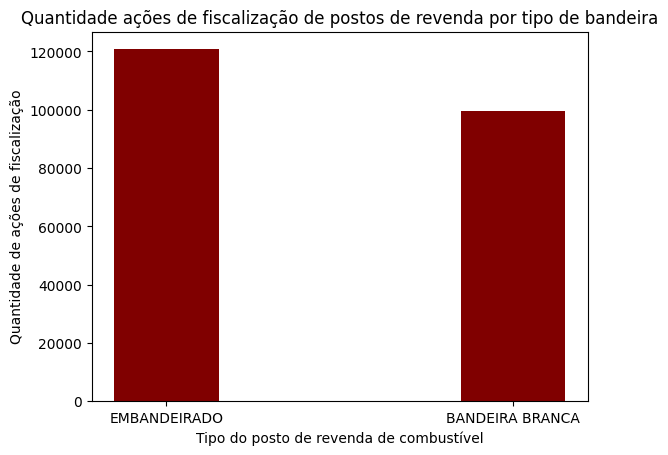

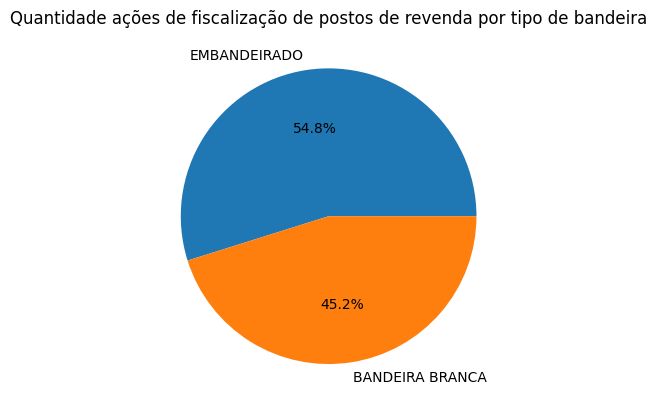

In [34]:
# dataframe final, limpo e com os dados que precisamos
df_final = df_fr_bandeira_combustiveis.drop(columns=["UF", "Municï¿½pio", "Bairro", "Endereï¿½o", "Segmento Fiscalizado", "Nï¿½mero do Documento"])
df_final

tipos_bandeira = df_final["Bandeira"].unique()
print(tipos_bandeira)
valores_tipos_bandeira = [num_registros_embandeirados, num_registros_bandeira_branca]

porcentagem_a_mais = (num_registros_embandeirados/num_registros_bandeira_branca * 100) - 100
print("Posts embandeirados recebem ", porcentagem_a_mais, "% mais ações de fiscalização")

plt.bar(tipos_bandeira, valores_tipos_bandeira, color="maroon", width=0.3)
plt.title("Quantidade ações de fiscalização de postos de revenda por tipo de bandeira")
plt.xlabel("Tipo do posto de revenda de combustível")
plt.ylabel("Quantidade de ações de fiscalização")
plt.show()

plt.pie(valores_tipos_bandeira, labels=tipos_bandeira, autopct='%1.1f%%')
plt.title("Quantidade ações de fiscalização de postos de revenda por tipo de bandeira")
plt.show()

Com isso, é possível afirmar que, em números absolutos (sem contar a proporção de postos para cada tipo de bandeira) postos embandeirados são mais fiscalizados que postos com bandeira branca. Mais precisamente postos embandeirados recebem 21,47% mais fiscalizações.

Numero total de revendedores:  44392
Numero de embandeirados:  23360
Numero de bandeira branca:  21032
Foram feitas  5.1693493150684935  ações de fiscalização por posto embandeirado
Foram feitas  4.726464435146443  ações de fiscalização por posto bandeira branca
Postos embandeirados recebem  9.37032079684586 % mais ações de fiscalização


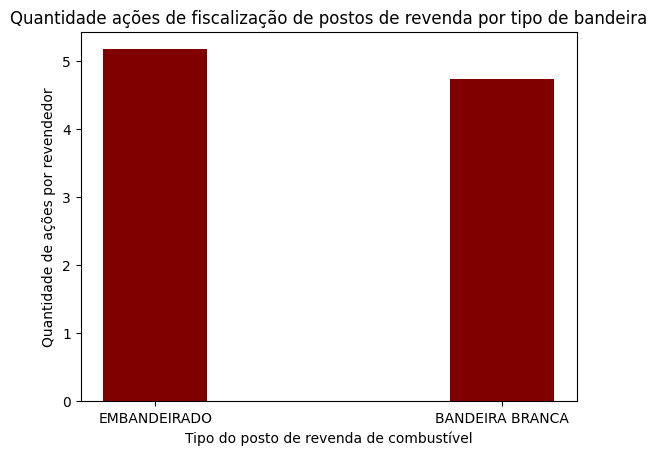

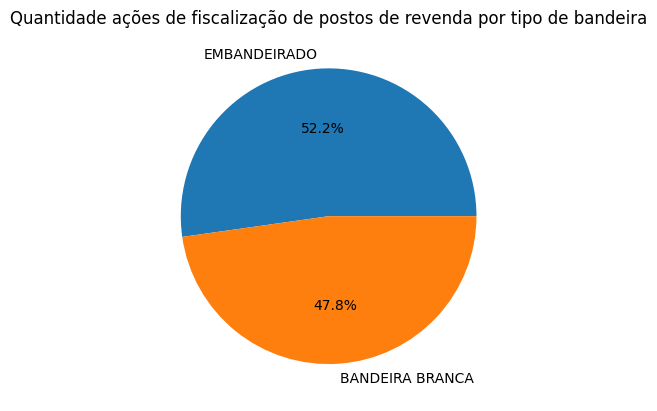

In [35]:
# Agora vamos buscar os dados em relação ao número de postos para cada
# tipo de bandeira

series_bandeiras = df_revendedores["Vinculação a Distribuidor"]
# series_bandeiras.rename(columns={"Vinculação a Distribuidor": "Bandeira"})

# separando dataframe novamente entre embandeirado e bandeira branca
num_revendedores = series_bandeiras.size

num_embandeirados = series_bandeiras[series_bandeiras != "BANDEIRA BRANCA"].size
num_bandeira_branca = series_bandeiras[series_bandeiras == "BANDEIRA BRANCA"].size

print("Numero total de revendedores: ", num_revendedores)
print("Numero de embandeirados: ", num_embandeirados)
print("Numero de bandeira branca: ", num_bandeira_branca)

valores_tipos_bandeira_proporcao = [
	num_registros_embandeirados/num_embandeirados,
	num_registros_bandeira_branca/num_bandeira_branca
]

print("Foram feitas ", valores_tipos_bandeira_proporcao[0], " ações de fiscalização por posto embandeirado")
print("Foram feitas ", valores_tipos_bandeira_proporcao[1], " ações de fiscalização por posto bandeira branca")

porcentagem_a_mais = (valores_tipos_bandeira_proporcao[0]/valores_tipos_bandeira_proporcao[1] * 100) - 100
print("Postos embandeirados recebem ", porcentagem_a_mais, "% mais ações de fiscalização")

plt.bar(tipos_bandeira, valores_tipos_bandeira_proporcao, color="maroon", width=0.3)
plt.title("Quantidade ações de fiscalização de postos de revenda por tipo de bandeira")
plt.xlabel("Tipo do posto de revenda de combustível")
plt.ylabel("Quantidade de ações por revendedor")
plt.show()

plt.pie(valores_tipos_bandeira_proporcao, labels=tipos_bandeira, autopct='%1.1f%%')
plt.title("Quantidade ações de fiscalização de postos de revenda por tipo de bandeira")
plt.show()

Agora, se colocarmos o número de ações de fiscalização em relação ao número total de revendedores, ainda temos que postos embandeirados são mais fiscalizados que postos de bandeira branca. Foream feitas 5.16 ações de fiscalização por posto embandeirado, enquanto o número para postos bandeira branca é de 4.72. Olhando o gráfico de pizza podemos ver que a proporção se mantém bastante parecida, apesar da diferença diminuir ligeiramente.

In [36]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")